<a href="https://colab.research.google.com/github/prayas99/SoC-2020-IDS/blob/master/Prayas_IDS_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import os


def combine_csv():
    data_files = sorted(glob('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/*.pcap_ISCX.csv'))
    ids = pd.read_csv(data_files[0])
    for i in range(1, len(data_files)):
        dfi = pd.read_csv(data_files[i])
        dfi.dropna(axis=0, how='any', inplace=True)
        ids = pd.concat((ids, dfi), ignore_index=True)

    del dfi
    print(ids.head())
    print(ids.head())
    ids.to_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv', index=False)


def resize_dataset():
    ids = pd.read_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv',
                      dtype={'Flow Bytes/s': str, ' Flow Packets/s': str})
    labels_to_drop = {'BENIGN': 0.1, 'DoS Hulk': 0.3, 'DDoS': 0.3, 'PortScan': 0.3}
    for label in labels_to_drop:
        df = ids.loc[ids[' Label'] == label]
        ids.drop(ids.index[ids[' Label'] == label], inplace=True)
        df = df.sample(frac=labels_to_drop[label])
        ids = pd.concat((ids, df), ignore_index=True)

    ids = ids.sample(frac=1, random_state=42)
    ids.reset_index(drop=True, inplace=True)
    ids['Flow Bytes/s'] = ids['Flow Bytes/s'].str.strip()
    ids[' Flow Packets/s'] = ids[' Flow Packets/s'].str.strip()
    ids = ids.astype({'Flow Bytes/s': float, ' Flow Packets/s': float})
    ids.columns = ids.columns.str.strip()
    ids.dropna(inplace=True)
    indices_to_keep = ~ids.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    ids = ids[indices_to_keep]
    ids.to_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv', index=False)
    return ids


def binary_label_encoder(y):
    '''
    converts multiclass labels to binary labels
    '''
    y["BinaryLabel"] = (y["Label"] != 'BENIGN').astype(int)

    return y


def split_dataset(df):
    '''
    Takes a dataframe df and splits it in 0.7:0.15:0.15 ratio for training, cross-validation and test sets.
    '''
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_index, test_index in split.split(df, df['BinaryLabel']):
        train = df.loc[train_index]
        test = df.loc[test_index]

    for train_index, cv_index in split.split(train, train['BinaryLabel']):
        train = df.loc[train_index]
        cv = df.loc[cv_index]

    return train, cv, test

if not os.path.isfile('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv'):
        combine_csv()
if not os.path.isfile('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv'):
        resize_dataset()




# Feature Selection

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
#from preprocessing import binary_label_encoder, split_dataset

dataset = pd.read_csv("/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv")
dataset = binary_label_encoder(dataset)
train, cv, test = split_dataset(dataset)


y_train = train[['BinaryLabel']]
X_train = train.drop(['Label', 'BinaryLabel'], axis=1, inplace=False)
cols = X_train.columns.tolist()
mm_scaler = MinMaxScaler()
X_new = X_train
X_new[cols] = mm_scaler.fit_transform(X_train[cols])
y_train = y_train['BinaryLabel'].values

y_test = test[['BinaryLabel']]
X_test = test.drop(['Label', 'BinaryLabel'], axis=1, inplace=False)
cols = X_test.columns.tolist()
mm_scaler = MinMaxScaler()
X_test = X_test
X_test[cols] = mm_scaler.fit_transform(X_test[cols])
y_test = y_test['BinaryLabel'].values

# Features needed can be changed below to get the top 'k'
# features for model training
features_needed = 15

######################################################################

print("Selection based on Pearson Correlation")


def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:, np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X_new, y_train, features_needed)
print(str(len(cor_feature)), 'selected features')
print(cor_feature)

#####################################################################

print("Selection based on chi square distibution")

chi_selector = SelectKBest(chi2, k=features_needed)
X_kbest_features = chi_selector.fit_transform(X_new, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_new.loc[:, chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)


# # More Raw Approach - Leaving the first 2 valued and
# # last NaN valued features, all other features are
# # dependent and can be considered for training

# print("Raw Approach of chi square")
# chi_scores = chi2(X_new,y)
# p_values = pd.Series(chi_scores[1],index = X_new.columns)
# p_values.sort_values(ascending = False , inplace = True)
# # p_values.plot.bar()
# # print(p_values)


Selection based on Pearson Correlation


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


15 selected features
['Flow IAT Max', 'Fwd IAT Max', 'Idle Max', 'Average Packet Size', 'Fwd IAT Std', 'Packet Length Mean', 'Packet Length Variance', 'Max Packet Length', 'Packet Length Std', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Min Packet Length', 'Bwd Packet Length Max', 'Bwd Packet Length Std']
Selection based on chi square distibution
15 selected features
['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Packet Length Std', 'Packet Length Variance', 'PSH Flag Count', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']


# Model nn

In [9]:
X1, Y1 = X_new[chi_feature], y_train
X2, Y2 = X_new[cor_feature], y_train

X_test ,Y_test = X_test[chi_feature], y_test

In [7]:
train_target = torch.tensor(Y1.astype(np.float32)) 
train = torch.tensor(X1.values.astype(np.float32)) 

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 64, shuffle = True)

NameError: ignored

In [ ]:
test_target = torch.tensor(Y_test.astype(np.float32))
test = torch.tensor(X_test.values.astype(np.float32)) 

test_tensor = data_utils.TensorDataset(test,test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 1, shuffle = False)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 6.
        self.layer_1 = nn.Linear(15, 34) 
        self.layer_2 = nn.Linear(34, 52)
        self.layer_out = nn.Linear(52, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(34)
        self.batchnorm2 = nn.BatchNorm1d(52)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
model = binaryClassification()
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

binaryClassification(
  (layer_1): Linear(in_features=15, out_features=34, bias=True)
  (layer_2): Linear(in_features=34, out_features=52, bias=True)
  (layer_out): Linear(in_features=52, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
EPOCHS = 1
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        #print(y_pred.size())
        #print(y_batch.size())
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        #print(loss.size())
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 1: | Loss: 0.25420 | Acc: 87.913


In [ ]:
y_pred_list = []
y_correct = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        #y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_correct.append(y_batch.numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_correct_list = [a.squeeze().tolist() for a in y_correct]

In [ ]:
y_pred_ana = []
y_pred_non = []
temp1 = len(y_correct_list)
for i in range(0,temp1):
  if y_correct_list[i] == 1:
    y_pred_ana.append(y_pred_list[i])
  else:  
    y_pred_non.append(y_pred_list[i])

y_pred_non = [i * 100 for i in y_pred_non]
y_pred_ana = [i * 100 for i in y_pred_ana]

Text(0, 0.5, 'Occurences')

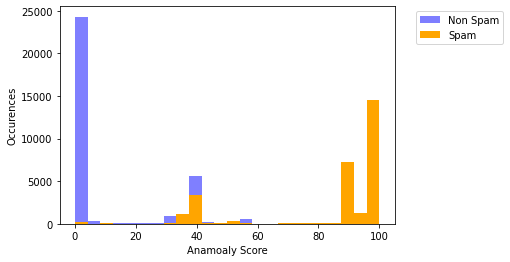

In [ ]:
data = y_pred_non
bins = np.linspace(0, 100, 25, endpoint=True)
plt.hist(data, bins,color = 'blue',alpha =0.5, label = 'Non Spam')

data1 = y_pred_ana
bins = np.linspace(0, 100, 25, endpoint=True)
plt.hist(data1, bins,color = 'orange', label = 'Spam')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Anamoaly Score')
plt.ylabel('Occurences')

In [ ]:
from sklearn.metrics import classification_report

test_labels = np.array(y_test)
y_pred_list = np.array(y_pred_list)


print(classification_report(test_labels, y_pred_list.round(), target_names=["Normal", "Abnormal"]))

# Model RF

In [10]:
x1,y1 = X_new[chi_feature], y_train
x_test,y_test = X_test[chi_feature],y_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 70)
classifier.fit(x1,y1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = classifier.predict(x_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test,y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[31288  2780]
 [ 7992 21211]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85     34068
           1       0.88      0.73      0.80     29203

    accuracy                           0.83     63271
   macro avg       0.84      0.82      0.83     63271
weighted avg       0.84      0.83      0.83     63271

Accuracy: 0.8297482258854768


# Hyperparameter Tuning

In [ ]:
model = classifier
grid = {'n_estimators': [10, 13,15,20,70,100,150]
        #'max_features': [0.05, 0.07, 0.15, 0.25],
        #'min_samples_split': [2, 10,50,200]
        }

rf_gridsearch = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=grid, n_jobs=4, 
                             cv=None, verbose=5, return_train_score=True)

rf_gridsearch.fit(x1, y1)

# and after some hours...
df_gridsearch = pd.DataFrame(rf_gridsearch.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  9.5min finished


In [ ]:
model = classifier
grid2 = {#'n_estimators': [10, 13,15,20,70,100,150]
        'max_features': [0.05, 0.07, 0.15, 0.25],
        #'min_samples_split': [2, 10,50,200]
        }

rf_gridsearch2 = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=grid2, n_jobs=4, 
                             cv=3, verbose=50, return_train_score=True)

rf_gridsearch2.fit(x1, y1)

# and after some hours...
df_gridsearch2 = pd.DataFrame(rf_gridsearch2.cv_results_)
print(df_gridsearch2.columns)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   40.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   41.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   42.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   6 out of  12 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  1.6min remaining:   46.7s
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  2.1min remaining:   43.0s
[Parallel(n_jobs=4)]: Done  10 out of  12 | elapsed:  2.3min remaining:   28.1s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  2.5min finished
Index(['me

In [ ]:
print(df_gridsearch2.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


In [ ]:
model = classifier
grid3 = {#'n_estimators': [10, 13,15,20,70,100,150]
        #'max_features': [0.05, 0.07, 0.15, 0.25],
        'min_samples_split': [2, 10,50,200]
        }

rf_gridsearch3 = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=grid3, n_jobs=4, 
                             cv=3, verbose=5, return_train_score=True)

rf_gridsearch3.fit(x1, y1)

# and after some hours...
df_gridsearch3 = pd.DataFrame(rf_gridsearch3.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  3.2min finished


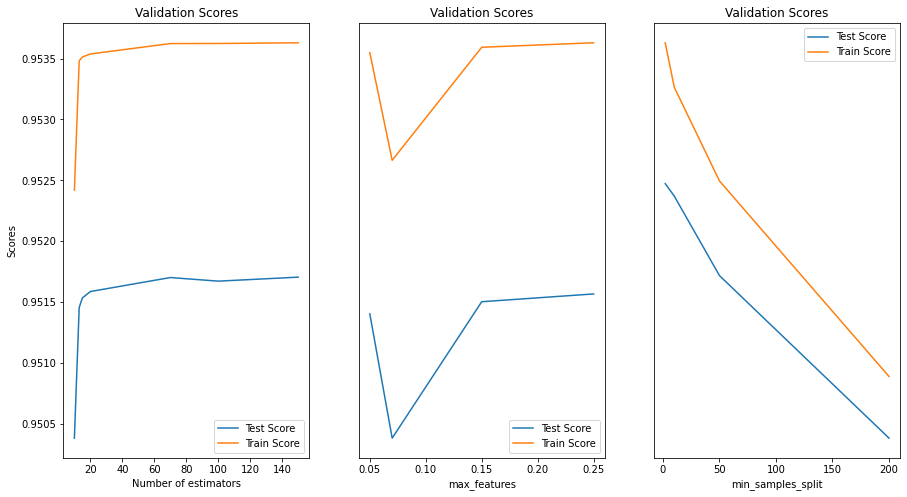

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))

sns.axes_style("darkgrid")
sns.lineplot(x="param_n_estimators", y="mean_test_score",
             data=df_gridsearch,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Test Score',ax=ax1)
sns.lineplot(x="param_n_estimators", y="mean_train_score",
             data=df_gridsearch,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Train Score',ax=ax1)
ax1.set(xlabel='Number of estimators', ylabel='Scores',title = "Validation Scores")
ax1.legend()

sns.lineplot(x="param_max_features", y="mean_test_score",
             data=df_gridsearch2,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Test Score',ax=ax2)
sns.lineplot(x="param_max_features", y="mean_train_score",
             data=df_gridsearch2,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Train Score',ax=ax2)
ax2.set(xlabel='max_features', ylabel='',title = "Validation Scores")
ax2.get_yaxis().set_ticks([])
ax2.legend()

sns.lineplot(x="param_min_samples_split", y="mean_test_score",
             data=df_gridsearch3,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Test Score',ax=ax3)
sns.lineplot(x="param_min_samples_split", y="mean_train_score",
             data=df_gridsearch3,markers=True, dashes=False,err_style=None,palette = 'Set1',label='Train Score',ax=ax3)
ax3.set(xlabel='min_samples_split', ylabel='',title = "Validation Scores")
ax3.get_yaxis().set_ticks([])
ax3.legend()

# Model SVM

In [11]:

import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [12]:
svc = LinearSVC()
svc.fit(x1,y1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
y_pred = svc.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[31288,  2780],
       [ 7992, 21211]])

In [18]:
result1 = classification_report(y_test,y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85     34068
           1       0.88      0.73      0.80     29203

    accuracy                           0.83     63271
   macro avg       0.84      0.82      0.83     63271
weighted avg       0.84      0.83      0.83     63271

Accuracy: 0.8297482258854768
